In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import math
import networkx as nx

In [4]:
north = 1.3646
south = 1.2705
east = 103.8895
west = 103.8215

# G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
G = ox.save_load.load_graphml(filename='Central_SG_drive.graphml')

# G_ped = ox.graph_from_bbox(north, south, east, west, network_type='walk', name='Central Singapore')
G_ped = ox.save_load.load_graphml(filename='Central_SG_walk.graphml')

# Stores nodes and edges along with other attributes
type(G)

networkx.classes.multidigraph.MultiDiGraph

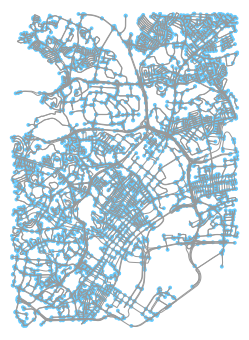

<Figure size 432x288 with 0 Axes>

In [53]:
# Blue == nodes, Gray == edges
fig, ax = ox.plot_graph(G)
plt.tight_layout()

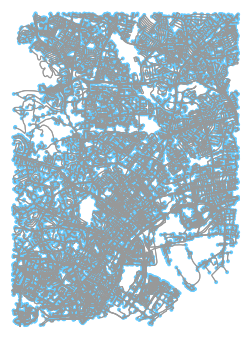

<Figure size 432x288 with 0 Axes>

In [54]:
# Blue == nodes, Gray == edges
fig, ax = ox.plot_graph(G_ped)
plt.tight_layout()

In [5]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
nodes_ped, edges_ped = ox.graph_to_gdfs(G_ped, nodes=True, edges=True)

In [6]:
# Preprocess drive network first
edges.head()

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,tunnel,bridge,ref,access,junction,service,width
0,233783297,4602578373,0,584496505,True,3,Nicoll Highway,trunk,70,13.191,"LINESTRING (103.85729 1.29555, 103.85736 1.29565)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,233783297,1398080906,0,"[748657114, 126016651, 634782242]",True,3,Middle Road,secondary,50,125.656,"LINESTRING (103.85729 1.29555, 103.85718 1.295...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,626491396,626491409,0,"[49331424, 49331425, 476986397]",True,"[2, 1]",NaN,motorway_link,50,807.791,"LINESTRING (103.87480 1.31420, 103.87480 1.314...",yes,NaN,NaN,NaN,NaN,NaN,NaN
3,626491396,626489006,0,"[476986393, 633262252]",True,"[2, 1]",NaN,motorway_link,50,501.189,"LINESTRING (103.87480 1.31420, 103.87474 1.314...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5015699464,2524914101,0,537159966,False,NaN,Bishan Street 15,residential,50,2.898,"LINESTRING (103.85040 1.35316, 103.85041 1.35318)",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def process_drive_edges(edges):
    # Drop unnecessary columns
    edges.drop(['lanes','name','tunnel','bridge','ref','junction','access','width','service'], axis=1, inplace=True)
    
    # Remove list from maxspeed
    i = 0
    
    for x in edges['maxspeed']:
        if type(x) == list:
            edges['maxspeed'][i] = max(x)
        i += 1    

    edges['maxspeed'] = edges['maxspeed'].astype(float)
    

    # Define free-flow time t(u,v) in sec
    travel_time = []
    
    for l,s in zip(edges['length'], edges['maxspeed']):
        t = (3600*l)/(1000*s)
        travel_time.append(t)
            
    edges['travel_time'] = travel_time


    # Define capacity for roads
    capacity = []
    
    for k,l in zip(edges['key'], edges['length']):
        c = math.floor((3*(1+k)*l)/6)
        capacity.append(c)
    
    edges['capacity'] = capacity

In [9]:
process_drive_edges(edges)
edges.head()

/home/orionstar25/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,u,v,key,osmid,oneway,highway,maxspeed,length,geometry,travel_time,capacity
0,233783297,4602578373,0,584496505,True,trunk,70.0,13.191,"LINESTRING (103.85729 1.29555, 103.85736 1.29565)",0.678394,6
1,233783297,1398080906,0,"[748657114, 126016651, 634782242]",True,secondary,50.0,125.656,"LINESTRING (103.85729 1.29555, 103.85718 1.295...",9.047232,62
2,626491396,626491409,0,"[49331424, 49331425, 476986397]",True,motorway_link,50.0,807.791,"LINESTRING (103.87480 1.31420, 103.87480 1.314...",58.160952,403
3,626491396,626489006,0,"[476986393, 633262252]",True,motorway_link,50.0,501.189,"LINESTRING (103.87480 1.31420, 103.87474 1.314...",36.085608,250
4,5015699464,2524914101,0,537159966,False,residential,50.0,2.898,"LINESTRING (103.85040 1.35316, 103.85041 1.35318)",0.208656,1


In [10]:
edges[edges['u'] == 6369755828]

,u,v,key,osmid,oneway,highway,maxspeed,length,geometry,travel_time,capacity
468,6369755828,384029628,0,"[476980002, 475952926, 652162871]",True,secondary,50.0,114.448,"LINESTRING (103.88181 1.35086, 103.88140 1.350...",8.240256,57
469,6369755828,384029628,1,"[740137529, 680287258, 680287259]",True,residential,50.0,125.456,"LINESTRING (103.88181 1.35086, 103.88167 1.350...",9.032832,125


In [15]:
G = ox.gdfs_to_graph(nodes, edges)
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [16]:
ox.save_load.save_graphml(G, filename='Central_SG_drive_processed.graphml')